# Credit card default dataset analysis and default prediction 

The code was executed on a machine with the following specifications. Any mentioned execution times correspond to this setup:

- Processor: 13th Gen Intel® Core™ i7-1355U @ 1.70 GHz
- RAM: 16.0 GB (15.6 GB usable)

Importing all the necessary datasets

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import numpy as np
import time

from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV, 
    cross_val_score, 
    learning_curve, 
    StratifiedKFold
    )

from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    f1_score,
    precision_score,
    accuracy_score,
    roc_curve, auc, precision_recall_curve
)
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC,LinearSVC
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline  
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier


In [2]:
df = pd.read_csv('credit_card_defaults.csv')
df_chng = df.copy()

# EDA and Data cleaning

In [3]:
df_chng.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0


Changing column names to be more intuitive and it becomes easier to work with

In [4]:
df_chng.columns = list(df.iloc[0].values)
df_chng.rename(columns={'PAY_0': 'PAY_1', 'default payment next month' : 'default_nxt'}, inplace=True)
df_chng = df_chng.drop(0).reset_index(drop=True)

df_chng['default_nxt'] = df_chng['default_nxt'].astype(int)
df_chng = df_chng.apply(pd.to_numeric, errors='coerce')

Examining the dataset

In [5]:
df_chng.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_nxt
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


Initial observations:
1. There are no missing values in the dataset. 
2. 22.12% of clients are defaults, which menas we are dealing with unbalanced dataset.
3. There are some values for marriage and education which are unknown.
4. Some bill columns have negative values, there are bills that exceed the max limit of the credit.

In [6]:
# As ID column does not have any significance, we can drop it
 
print(df_chng.duplicated().sum())
df_chng.drop(['ID'], axis=1, inplace=True)
print(df_chng.duplicated().sum())

0
35


After dropping ID some duplicates appear, so we drop them to not have impact on analysis and model performance

In [7]:
df_chng.drop_duplicates(inplace=True)

In [8]:
pay_status_columns = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
pay_amt_columns = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
bill_amt_columns = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']

In [9]:
max_limit = df_chng['LIMIT_BAL'].max()

limit_exceeded = df_chng[
    (df_chng['BILL_AMT1'] > max_limit) | 
    (df_chng['BILL_AMT2'] > max_limit) | 
    (df_chng['BILL_AMT3'] > max_limit) | 
    (df_chng['BILL_AMT4'] > max_limit) | 
    (df_chng['BILL_AMT5'] > max_limit) | 
    (df_chng['BILL_AMT6'] > max_limit)]

limit_exceeded.shape

(1, 24)

There is one client that has bill amount which is more than the max limit of the dataset, so can be better to drop that. 

In [10]:
df_chng.drop(limit_exceeded.index, inplace=True)

In [11]:
limit_exceeded = df_chng[
    (df_chng['BILL_AMT1'] > df_chng['LIMIT_BAL']) | 
    (df_chng['BILL_AMT2'] > df_chng['LIMIT_BAL']) | 
    (df_chng['BILL_AMT3'] > df_chng['LIMIT_BAL']) | 
    (df_chng['BILL_AMT4'] > df_chng['LIMIT_BAL']) | 
    (df_chng['BILL_AMT5'] > df_chng['LIMIT_BAL']) | 
    (df_chng['BILL_AMT6'] > df_chng['LIMIT_BAL'])]

limit_exceeded['default_nxt'].value_counts()

default_nxt
0    2747
1    1183
Name: count, dtype: int64

About 43% of clients that exceeded their limit becomed deafult so it may be useful feature to add to the dataset

In [12]:
# Copying to another dataset to try models with 
# and without added/removed features

df_featured = df_chng.copy()
df_featured['over_limit'] = (
    (df_chng['BILL_AMT1'] > df_chng['LIMIT_BAL']) | 
    (df_chng['BILL_AMT2'] > df_chng['LIMIT_BAL']) | 
    (df_chng['BILL_AMT3'] > df_chng['LIMIT_BAL']) | 
    (df_chng['BILL_AMT4'] > df_chng['LIMIT_BAL']) | 
    (df_chng['BILL_AMT5'] > df_chng['LIMIT_BAL']) | 
    (df_chng['BILL_AMT6'] > df_chng['LIMIT_BAL'])).astype(int)

In [13]:
df_featured['over_limit'].value_counts()

over_limit
0    26034
1     3930
Name: count, dtype: int64

Dealing with some undocumented values in MARRIAGE and EDUCATION columns

In [14]:
print(df_chng['MARRIAGE'].value_counts().sort_index())
print(df_chng['EDUCATION'].value_counts().sort_index())

MARRIAGE
0       54
1    13642
2    15945
3      323
Name: count, dtype: int64
EDUCATION
0       14
1    10562
2    14019
3     4915
4      123
5      280
6       51
Name: count, dtype: int64


- Replace values (0, 5, 6) for Education with 4 (Others) as no specific information is available for these categories.
- Change value 0 to 3 (Others) for Marriage.

In [15]:
fil = (df_chng['EDUCATION'] == 5) | (df_chng['EDUCATION'] == 6) | (df_chng['EDUCATION'] == 0)
df_chng.loc[fil, 'EDUCATION'] = 4

fil = (df_chng['MARRIAGE'] == 0)
df_chng.loc[fil, 'MARRIAGE'] = 3

# Adding some additional features to copied dataframe

In [ ]:
df_featured['TOTAL_OVERDUE'] = (df_chng[pay_status_columns] > 0).sum(axis=1)
df_featured['TOTAL_NOT_USED'] = (df_chng[pay_status_columns] == -2).sum(axis=1)
df_featured['TOTAL_FULLY_REPAID'] = (df_chng[pay_status_columns] == -1).sum(axis=1)
df_featured['TOTAL_REVOLVING'] = (df_chng[pay_status_columns] == 0).sum(axis=1)

df_featured['AVG_BILL'] = df_chng[bill_amt_columns].mean(axis=1)
df_featured['AVG_PAYMENT'] = df_chng[pay_amt_columns].mean(axis=1)
df_featured['AVG_PAYMENT_TO_BILL_RATIO'] = df_featured['AVG_PAYMENT'] / df_featured['AVG_BILL'].replace(0, 1)
df_featured['AVG_UTILIZATION'] = df_featured['AVG_BILL'] / df_chng['LIMIT_BAL'].replace(0, 1)

df_featured['TOTAL_DUE'] = df_chng[bill_amt_columns].sum(axis=1) - df_chng[pay_amt_columns].sum(axis=1)
df_featured['TOTAL_DUE_TO_LIMIT_RATIO'] = df_featured['TOTAL_DUE'] / df_featured['LIMIT_BAL'].replace(0, 1)

# Changing the AGE and LIMIT_BAL columns to categorical
df_featured['AGE_GROUP'] = pd.cut(df_chng['AGE'], bins=[20, 30, 40, 50, 60, 70, 80],
                              labels=[2,3,4,5,6,7],
                              right=False)

df_featured['LIMIT_BAL_GROUP'] = pd.cut(df_chng['LIMIT_BAL'], 
                                    bins=np.linspace(10_000, 1_000_001, 10),  
                                    labels=[10, 120, 230, 340, 450, 560, 670, 780, 890],
                                    include_lowest=True)

df_featured.drop(['AGE', 'LIMIT_BAL'], axis=1, inplace=True)


# Data visualization and analysis

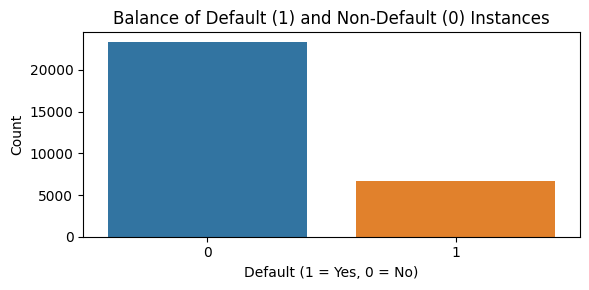

In [17]:
plt.figure(figsize=(6, 3))
sns.countplot(hue="default_nxt", x="default_nxt", data=df_chng, palette="tab10", legend=False)
plt.title("Balance of Default (1) and Non-Default (0) Instances")
plt.xlabel("Default (1 = Yes, 0 = No)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


We have an unbalanced dataset, with default instances accounting for only about 22%. This can impact our classifiaction models.

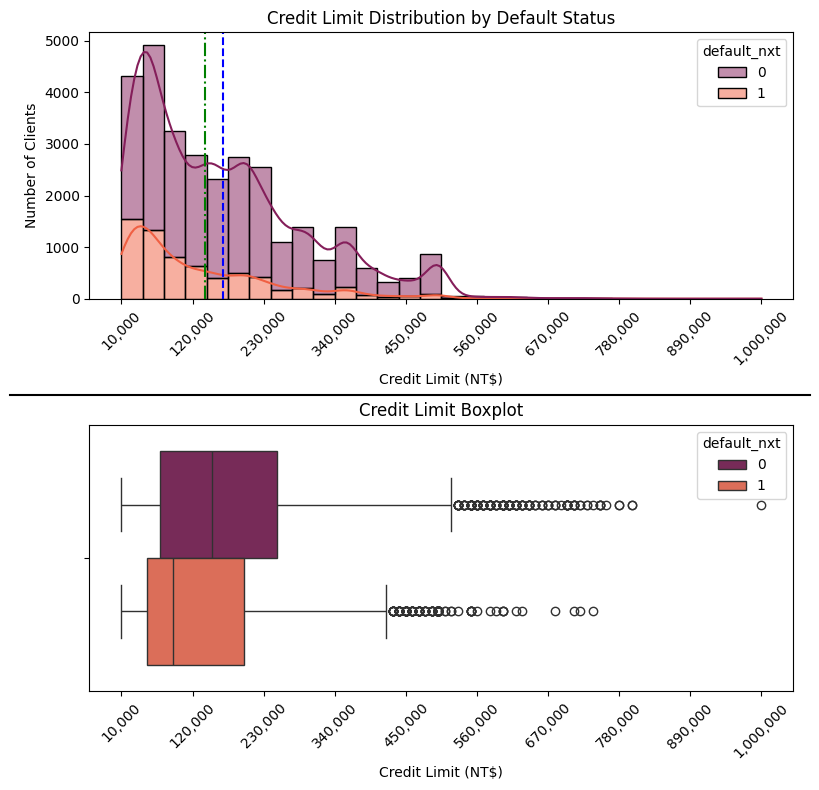

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
x_min, x_max = df_chng['LIMIT_BAL'].min(), df_chng['LIMIT_BAL'].max()

sns.histplot(data=df_chng, x='LIMIT_BAL', hue='default_nxt', multiple='stack', kde=True, palette='rocket', bins=30, ax=ax1)

ax1.axvline(df_chng['LIMIT_BAL'].mean(), color='blue', linestyle='--', label='Mean')
ax1.axvline(df_chng['LIMIT_BAL'].median(), color='green', linestyle='-.', label='Median')

ax1.set_title('Credit Limit Distribution by Default Status')
ax1.set_xlabel('Credit Limit (NT$)')
ax1.set_ylabel('Number of Clients')

# Set x-axis ticks with more points for the histogram
ax1.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))
ax1.set_xticks(np.linspace(x_min, x_max, 10))
ax1.tick_params(axis='x', rotation=45)

sns.boxplot(x=df_chng['LIMIT_BAL'], ax=ax2, palette='rocket', hue=df_chng['default_nxt'])
ax2.set_title('Credit Limit Boxplot')
ax2.set_xlabel('Credit Limit (NT$)')

# Set x-axis ticks with more points for the boxplot
ax2.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))
ax2.set_xticks(np.linspace(x_min, x_max, 10))
ax2.tick_params(axis='x', rotation=45)

fig.subplots_adjust(hspace=0.5)
line = plt.Line2D([0, 1], [0.5, 0.5], transform=fig.transFigure, color="black")
fig.add_artist(line)

plt.tight_layout()
plt.show()

Observations:
Both plots indicate that the overall data is right-skewed.

- Most clients have credit limits between 10_000 and 230_000 NT$.
- Defaulting clients generally have lower credit limits, with a few outliers.
- As the credit limit increases, the number of both defaulting and non-defaulting clients decreases.
- However, for higher credit limits (beyond 300_000 NT$), the number of defaulting clients is significantly lower compared to non-defaulting clients.
- The median credit limit for non-defaulting clients is higher than for defaulting clients.
- The box for defaulting clients is narrower, indicating less variability in their credit limits compared to non-defaulting clients.


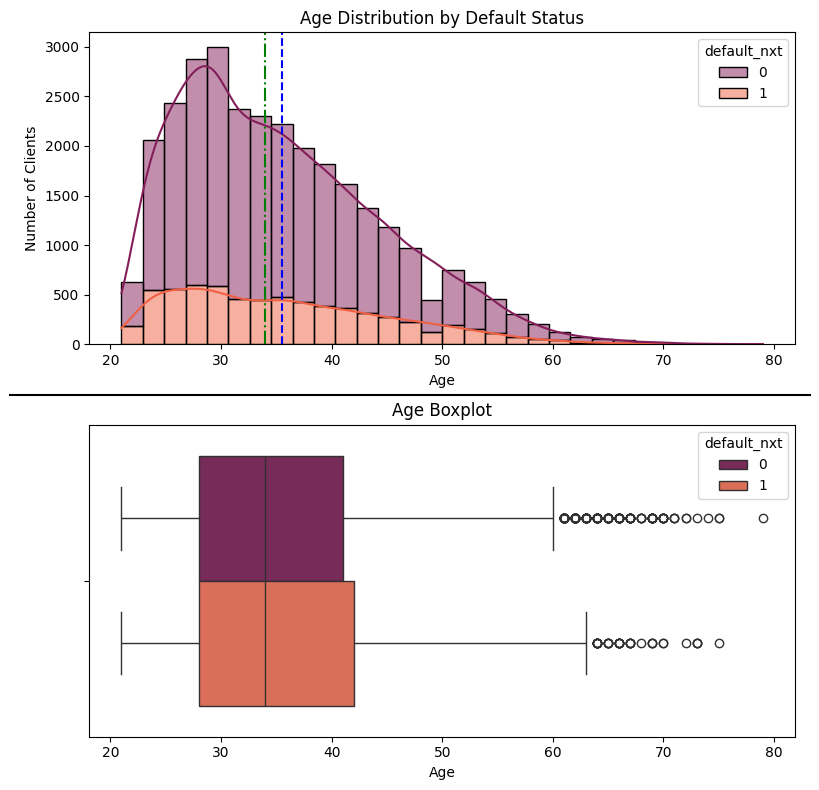

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

sns.histplot(data=df_chng, x='AGE', hue='default_nxt', multiple='stack', kde=True, palette='rocket', bins=30, ax=ax1)

ax1.axvline(df_chng['AGE'].mean(), color='blue', linestyle='--', label='Mean')
ax1.axvline(df_chng['AGE'].median(), color='green', linestyle='-.', label='Median')

ax1.set_title('Age Distribution by Default Status')
ax1.set_xlabel('Age')
ax1.set_ylabel('Number of Clients')

sns.boxplot(x=df_chng['AGE'], ax=ax2, palette='rocket', hue=df_chng['default_nxt'])
ax2.set_title('Age Boxplot')
ax2.set_xlabel('Age')

fig.subplots_adjust(hspace=0.5)
line = plt.Line2D([0, 1], [0.5, 0.5], transform=fig.transFigure, color="black")
fig.add_artist(line)

plt.tight_layout()
plt.show()

Observations: The age distribution is right-skewed.
- Most defaults occur in the younger age groups (25 to 40 years). 
- The density of defaulters decreases as age increases.

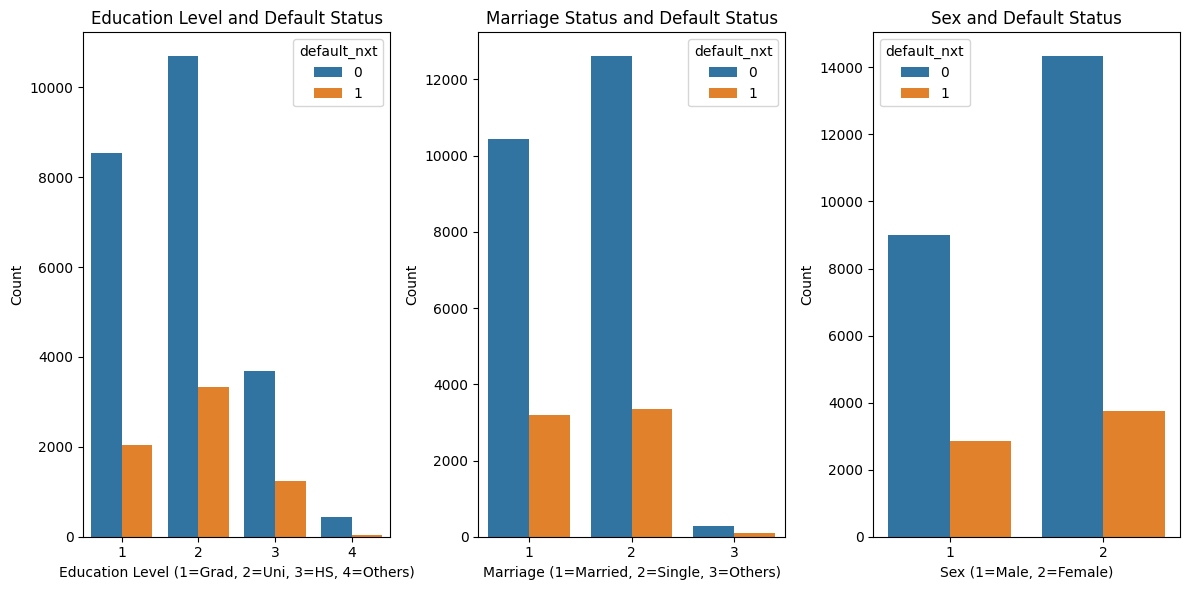

In [20]:
# PLotting categorical values 

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
sns.countplot(data=df_chng, x='EDUCATION', hue='default_nxt', palette='tab10')
plt.title('Education Level and Default Status')
plt.xlabel('Education Level (1=Grad, 2=Uni, 3=HS, 4=Others)')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
sns.countplot(data=df_chng, x='MARRIAGE', hue='default_nxt', palette='tab10')
plt.title('Marriage Status and Default Status')
plt.xlabel('Marriage (1=Married, 2=Single, 3=Others)')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
sns.countplot(data=df_chng, x='SEX', hue='default_nxt', palette='tab10')
plt.title('Sex and Default Status')
plt.xlabel('Sex (1=Male, 2=Female)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


Observations:

- The majority of clients fall into education levels 1 and 2, followed by level 3.
- Defaults are more prevalent in University education level.

- Married (1) and single (2) clients dominate the dataset. The "others" category still has a small number of clients but shows a relatively high proportion of defaults.
- Married clients appear to have a higher probability of defaulting compared to single clients.

- Female clients (2) outnumber male clients (1) in the dataset.
- The proportion of defaults is slightly higher for males.

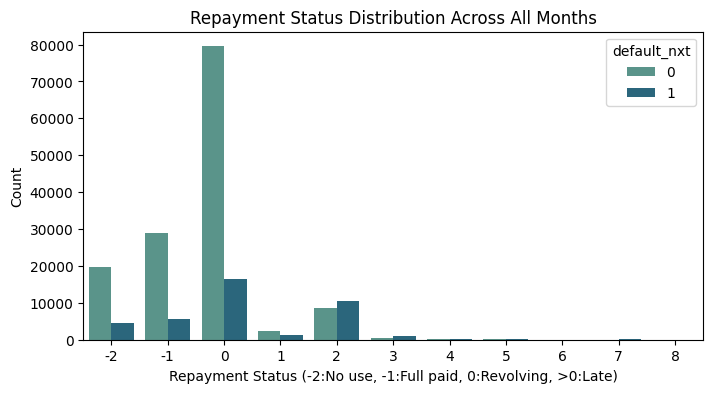

In [21]:
df_melted = df_chng.melt(id_vars='default_nxt', value_vars=pay_status_columns, var_name='Month', value_name='Status')

plt.figure(figsize=(8, 4))
sns.countplot(data=df_melted, x='Status', hue='default_nxt', palette='crest')
plt.title('Repayment Status Distribution Across All Months')
plt.xlabel('Repayment Status (-2:No use, -1:Full paid, 0:Revolving, >0:Late)')
plt.ylabel('Count')
plt.show()

Overall, revolving credit (0) dominantes the dataset. For better investigation we can plot log of values.

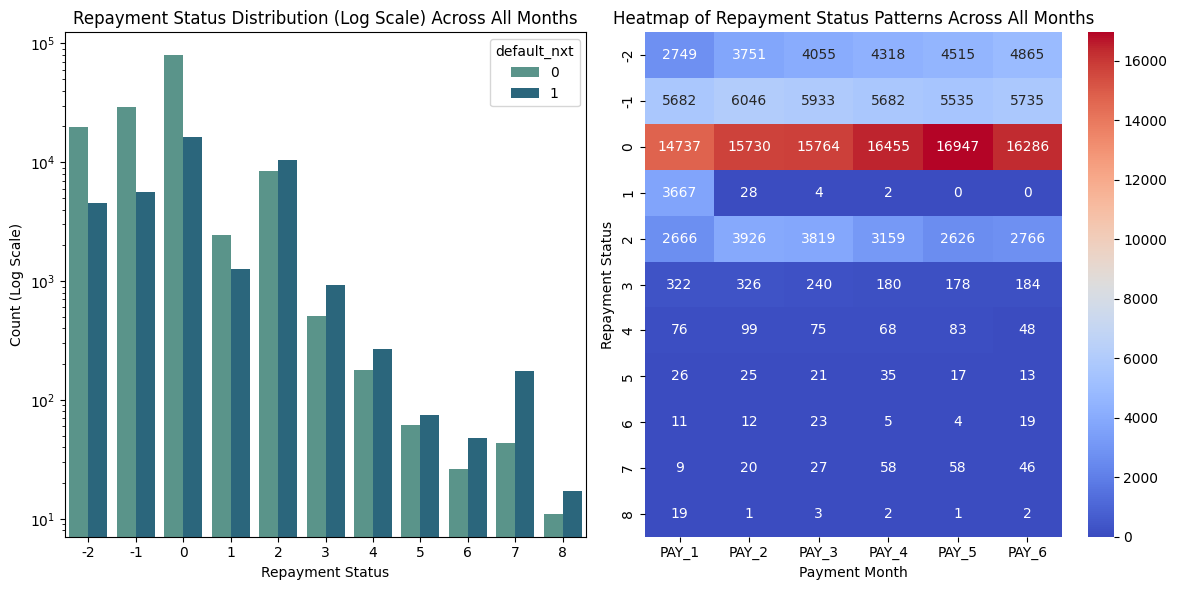

In [22]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.countplot(data=df_melted, x='Status', hue='default_nxt', palette='crest')
plt.yscale('log')
plt.title('Repayment Status Distribution (Log Scale) Across All Months')
plt.xlabel('Repayment Status')
plt.ylabel('Count (Log Scale)')

plt.subplot(1, 2, 2)
pivot_table = pd.crosstab(df_melted['Status'], df_melted['Month'])
sns.heatmap(pivot_table, cmap='coolwarm', annot=True, fmt='g')
plt.title('Heatmap of Repayment Status Patterns Across All Months')
plt.xlabel('Payment Month')
plt.ylabel('Repayment Status')

plt.tight_layout()
plt.show()

Key Observations

- No credit use (status -2) shows a slight increasing trend from PAY_1 (September) to PAY_6 (April), 
indicating a decrease from April to September.
- Paid in full (status -1) remains stable, maintaining around 5,5000-6000 cases monthly.
- Revolving credit (status 0) is most prevalent, representing about half of clients consistently across all months.
Payment delays:
- 1-2 month delays are generally common. Status 1 shows an unusual spike in PAY_1 (September) with 3,688 cases, 
dropping dramatically afterwards (Actually increased dramatically in Semptember). Excluding this anomaly, 
2-3 month delays are actually more common than 1-month delays
- Severe delays (status 3-8) remain consistently rare, though customers who eventually default show higher proportions in these categories.

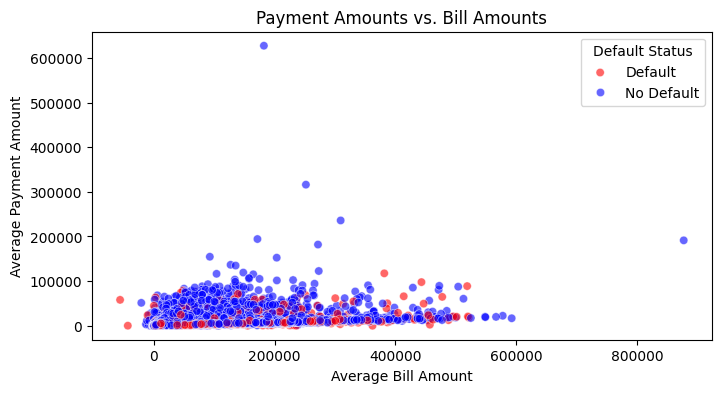

In [23]:
plt.figure(figsize=(8, 4))
sns.scatterplot(
    x=df_featured['AVG_BILL'],
    y=df_featured['AVG_PAYMENT'],
    hue=df_chng['default_nxt'],  
    palette={0: "blue", 1: "red"},  
    alpha=0.6
)

plt.xlabel("Average Bill Amount")
plt.ylabel("Average Payment Amount")
plt.title("Payment Amounts vs. Bill Amounts")
plt.legend(title="Default Status", labels=["Default", "No Default"])
plt.show()


Here we can notice 2 obvious outliers, that will be better to remove for better performance later.

In [24]:
# Find the indexes of the maximum values
max_avg_payment_index = df_featured['AVG_PAYMENT'].idxmax()
max_avg_bill_index = df_featured['AVG_BILL'].idxmax()

df_featured.drop([max_avg_payment_index, max_avg_bill_index], inplace=True)
df_featured.reset_index(drop=True, inplace=True)
df_chng.drop([max_avg_payment_index, max_avg_bill_index], inplace=True)
df_chng.reset_index(drop=True, inplace=True)

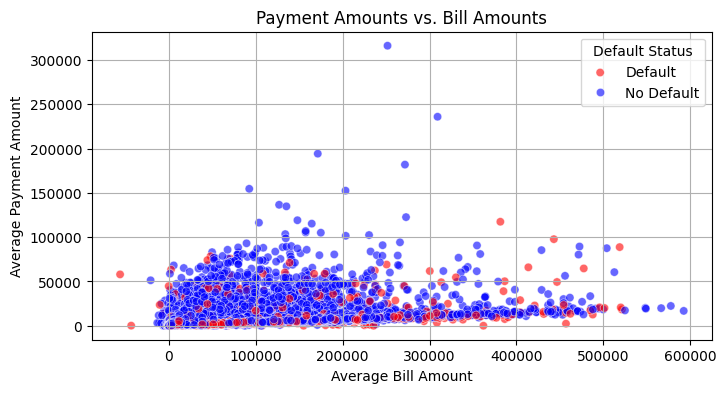

In [25]:
# Plotting the same once more 

plt.figure(figsize=(8, 4))
sns.scatterplot(
    x=df_featured['AVG_BILL'],
    y=df_featured['AVG_PAYMENT'],
    hue=df_chng['default_nxt'],  
    palette={0: "blue", 1: "red"},  
    alpha=0.6
)
plt.grid(True)
plt.xlabel("Average Bill Amount")
plt.ylabel("Average Payment Amount")
plt.title("Payment Amounts vs. Bill Amounts")
plt.legend(title="Default Status", labels=["Default", "No Default"])
plt.show()


Observations:

- Most customers have average bill and payment amounts clustered in the lower range (below 150_000).

- There appears to be a higher concentration of defaults in cases where payment amounts are notably lower than bill amounts.
The red points tend to cluster more in the lower payment amounts relative to their bill amounts, suggesting that customers who consistently pay less than their bills are at higher risk of default

- There seems to be a roughly linear relationship between bills and payments for non-defaulting customers, while defaulting customers show more scattered payment patterns.

- We can imply that the ratio between payments and bills could be a strong predictor of default risk, particularly when payments are consistently lower than bills. 

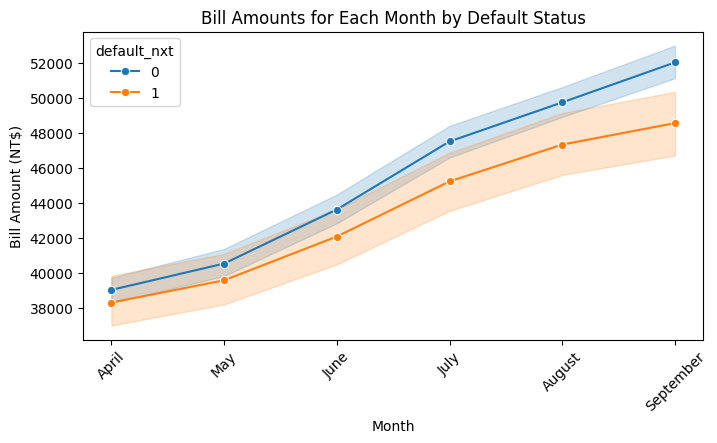

In [26]:
month_mapping = {
    'BILL_AMT6': 'April',
    'BILL_AMT5': 'May',
    'BILL_AMT4': 'June',
    'BILL_AMT3': 'July',
    'BILL_AMT2': 'August',
    'BILL_AMT1': 'September'
}

df_bill_renamed = df_chng.rename(columns=month_mapping)

bill_columns_ordered = ['April', 'May', 'June', 'July', 'August', 'September']
df_bill = df_bill_renamed[['default_nxt'] + bill_columns_ordered]

df_bill_melted = df_bill.melt(id_vars=['default_nxt'], value_vars=bill_columns_ordered, 
                              var_name='Month', value_name='Bill_Amount')

plt.figure(figsize=(8, 4))
sns.lineplot(data=df_bill_melted, x='Month', y='Bill_Amount', hue='default_nxt', 
             marker='o')
plt.title('Bill Amounts for Each Month by Default Status')
plt.xlabel('Month')
plt.ylabel('Bill Amount (NT$)')
plt.xticks(rotation=45)
plt.show()


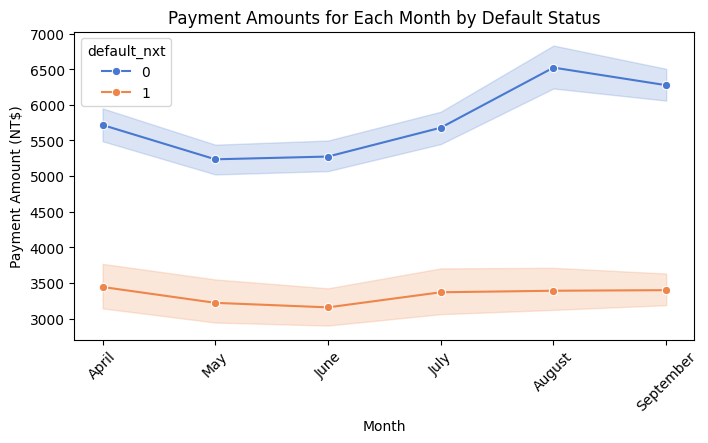

In [27]:
pay_mapping = {
    'PAY_AMT6': 'April',
    'PAY_AMT5': 'May',
    'PAY_AMT4': 'June',
    'PAY_AMT3': 'July',
    'PAY_AMT2': 'August',
    'PAY_AMT1': 'September'
}

df_pay_renamed = df_chng.rename(columns=pay_mapping)

pay_columns_ordered = ['April', 'May', 'June', 'July', 'August', 'September']
df_pay = df_pay_renamed[['default_nxt'] + pay_columns_ordered]

df_pay_melted = df_pay.melt(id_vars=['default_nxt'], value_vars=pay_columns_ordered, 
                            var_name='Month', value_name='Payment_Amount')

plt.figure(figsize=(8, 4))
sns.lineplot(data=df_pay_melted, x='Month', y='Payment_Amount', hue='default_nxt', 
             marker='o', palette='muted', sort=False)
plt.title('Payment Amounts for Each Month by Default Status')
plt.xlabel('Month')
plt.ylabel('Payment Amount (NT$)')
plt.xticks(rotation=45)
plt.show()


Bill Amounts Chart:

- Both defaulters and non-defaulters show an increasing trend in bill amounts from April to September.
- Non-defaulters (0) consistently maintain higher bill amounts.
- The gap between defaulters and non-defaulters widens over time.

Payment Amounts Chart:

- Shows a sharp contrast between defaulters and non-defaulters

Non-defaulters (0):
- Make significantly higher payments 
- Show varying payment patterns
- Generally maintain payments above 5000 NT$

Defaulters (1):
- Make consistently lower payments (around 3500 NT$)
- Show very little variation in payment amounts across months, maintaining a relatively flat payment pattern

The key insight here is that while both groups accumulate higher bills over time, non-defaulters maintain higher and more flexible payment amounts, while defaulters show consistently lower payments despite rising bills. This growing gap between bills and payments for defaulters likely contributes to their eventual default status.

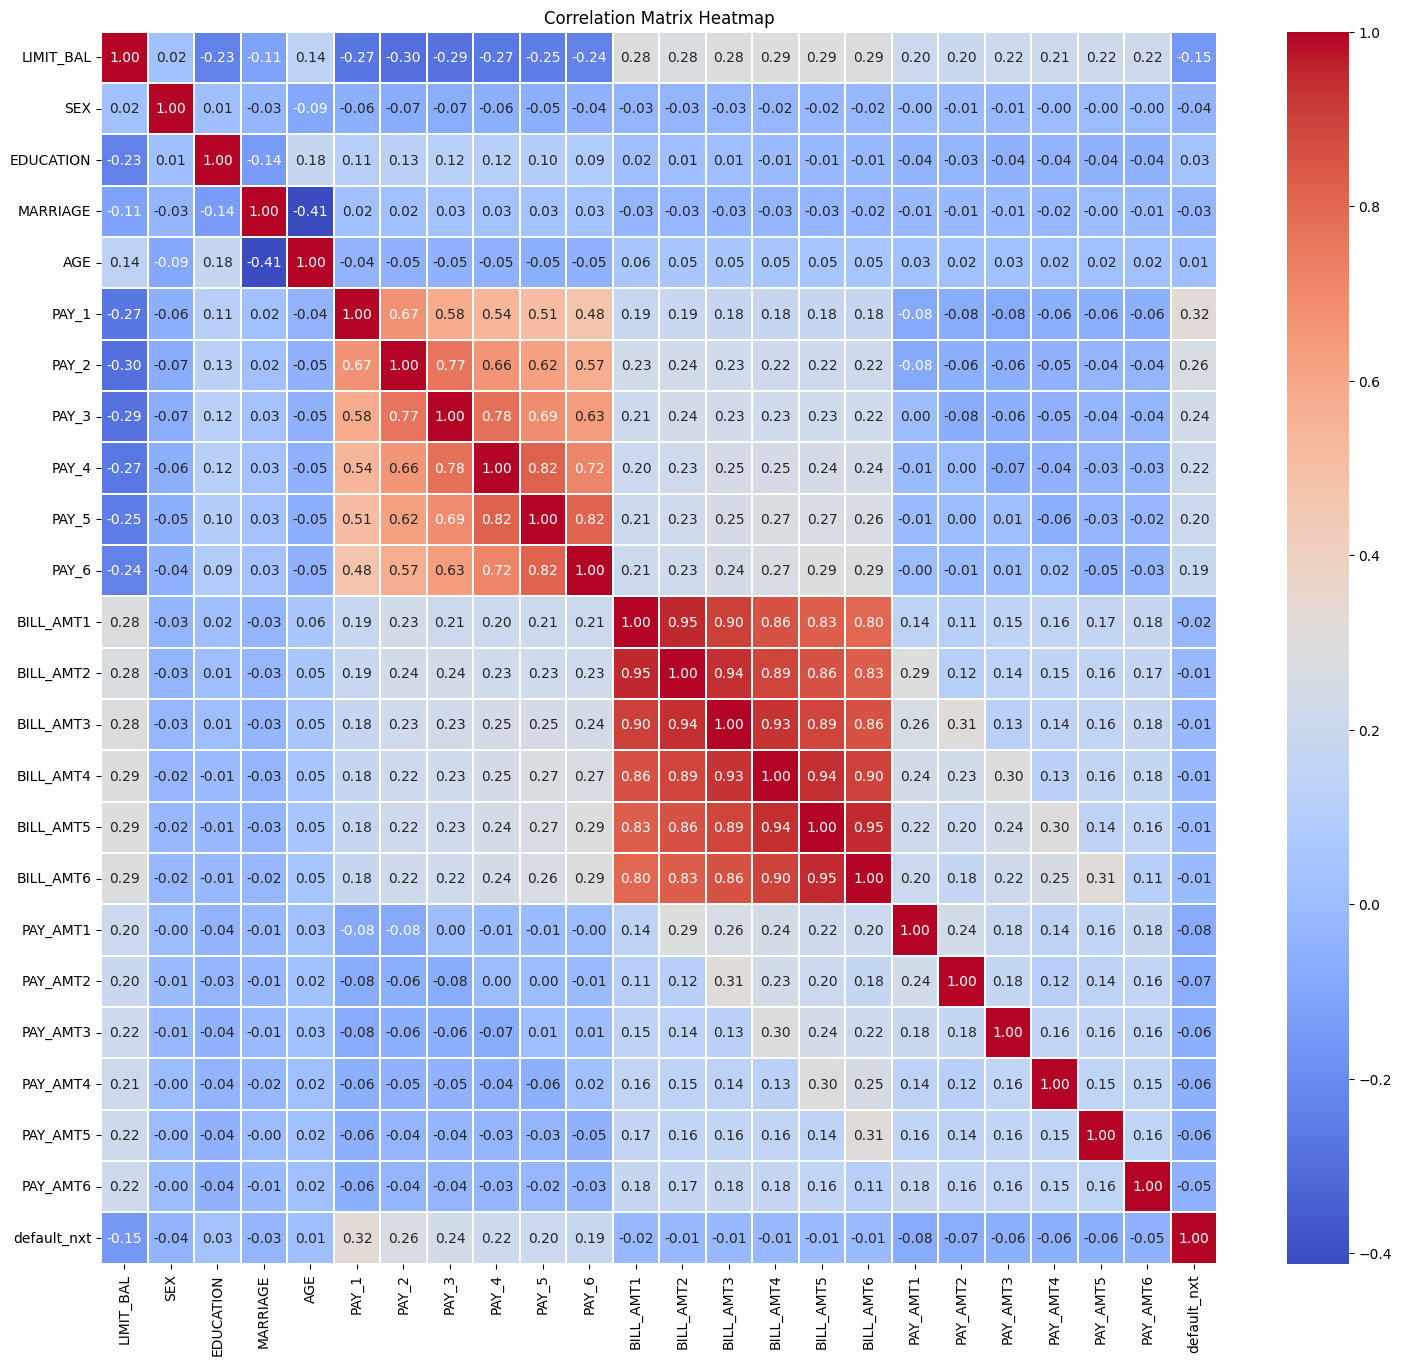

In [28]:
plt.figure(figsize=(18, 16))
sns.heatmap(df_chng.corr(), cmap="coolwarm", annot=True, linewidths=0.1, fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()

Payment Status Correlations (PAY_1 to PAY_6):

- Strong positive correlations between consecutive months
- Suggests that payment behavior in one month is a good predictor of the next month
- The correlation gets slightly weaker as months get further


Bill Amounts (BILL_AMT1 to BILL_AMT6):

- Very strong positive correlations between all bill amounts
- This indicates customers tend to maintain similar bill levels across months

Payment Amounts (PAY_AMT1 to PAY_AMT6):

- Moderate positive correlations with each other
- Less strongly correlated than bill amounts
- Suggests more variability in how much people pay each month

Demographic Features:

- EDUCATION, MARRIAGE, SEX, and AGE show very weak correlations, only AGE and MARRIAGE having higher negative correlation

LIMIT_BAL (Credit Limit):

- Weak to moderate correlations with bill amounts
- Suggests higher credit limits don't necessarily lead to higher usage or default
- Negative correlation with payment status. 

default_nxt (Default Prediction):

- Shows weak to moderate positive correlations with payment status (PAY_1 to PAY_6)
- Negative correlations with limit amount

# Continuing feature engineering

So far we have changed the initial dataframe the way that it has additional features (df_featured). Now lets find the most important ones.

In [29]:
def select_top_features(df, target_column, top_n=10):
    # Automatically selects the top N features using Logistic Regression, Random Forest, SVM, and Mutual Information.

    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    # One-hot encode categorical variables
    X = pd.get_dummies(X, drop_first=True)
    feature_names = X.columns
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Standardize numerical features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Logistic Regression Feature Importance, using l1 penalty to drop unnecessary features
    log_reg = LogisticRegression(max_iter=500, random_state=42, penalty='l1', solver='liblinear')
    log_reg.fit(X_train, y_train)
    log_importance = np.abs(log_reg.coef_[0])
    
    # Random Forest Feature Importance
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    rf_importance = rf.feature_importances_
    
    # SVM Feature Importance
    svm = LinearSVC(random_state=42, max_iter=1000)
    svm.fit(X_train, y_train)
    svm_importance = np.abs(svm.coef_[0])
    
    # Mutual Information
    mi = mutual_info_classif(X_train, y_train, discrete_features='auto', random_state=42)
    
    # DataFrame with rankings
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Logistic_Regression": log_importance,
        "Random_Forest": rf_importance,
        "SVM": svm_importance,
        "Mutual_Information": mi
    })
    
    importance_df["Average_Rank"] = (
        importance_df.rank(method="min", ascending=False)[["Logistic_Regression", "Random_Forest", "SVM", "Mutual_Information"]]
        .mean(axis=1)
    )
    
    importance_df = importance_df.sort_values(by="Average_Rank")
    
    return importance_df.head(top_n)


In [30]:
df_featured_drop = df_featured.drop(pay_status_columns + pay_amt_columns + bill_amt_columns, axis=1, inplace=False)

top_features_drop = select_top_features(df_featured_drop, target_column="default_nxt", top_n=10)
top_features = select_top_features(df_featured, target_column="default_nxt", top_n=10)
top_features_chng = select_top_features(df_chng, target_column="default_nxt", top_n=10)

In [31]:
combined_df = pd.concat([top_features_drop.iloc[:,[0,-1]].reset_index(drop=True), 
                         top_features.iloc[:,[0,-1]].reset_index(drop=True), 
                         top_features_chng.iloc[:,[0,-1]].reset_index(drop=True)
                         ], axis=1)
combined_df.columns = ['Dropped', 'Avg_rank1', 'Featured', 'Avg_rank2', 'Initial', 'Avg_rank3']

features = set()

for i in range (combined_df.shape[0]):
    if combined_df['Avg_rank1'][i] <= 10:
        features.add(combined_df['Dropped'][i])
    if combined_df['Avg_rank2'][i] <= 10:
        features.add(combined_df['Featured'][i])
    if combined_df['Avg_rank3'][i] <= 10:
        features.add(combined_df['Initial'][i])
    
features


{'AVG_PAYMENT',
 'AVG_PAYMENT_TO_BILL_RATIO',
 'AVG_UTILIZATION',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT5',
 'BILL_AMT6',
 'LIMIT_BAL',
 'LIMIT_BAL_GROUP_120',
 'PAY_1',
 'PAY_2',
 'PAY_AMT1',
 'PAY_AMT2',
 'TOTAL_DUE',
 'TOTAL_DUE_TO_LIMIT_RATIO',
 'TOTAL_OVERDUE',
 'TOTAL_REVOLVING'}

From the average ranks we get that 18 features from initial and added ones can be more descriptive.

In [ ]:
# Reconstracting the dataset for further use

df_featured = pd.get_dummies(df_featured, drop_first=True)
df_chng = pd.get_dummies(df_chng, drop_first=True)

encoded_feature_names = set(df_featured.columns)  # Get the actual encoded column names
filtered_features = [f for f in features if f in encoded_feature_names]

df_combined = pd.concat([df_featured, df_chng], axis=1)
df_featured = df_combined.loc[:, ~df_combined.columns.duplicated()][filtered_features + ['default_nxt']]

df_featured

,PAY_2,BILL_AMT5,AVG_PAYMENT_TO_BILL_RATIO,AVG_UTILIZATION,TOTAL_REVOLVING,PAY_1,TOTAL_DUE_TO_LIMIT_RATIO,TOTAL_DUE,PAY_AMT1,BILL_AMT6,PAY_AMT2,AVG_PAYMENT,BILL_AMT3,LIMIT_BAL_GROUP_120,TOTAL_OVERDUE,BILL_AMT2,BILL_AMT1,default_nxt
0,2,0,0.089434,0.064200,0,2,0.350750,7015,0,0,689,114.833333,689,False,2,3102,3913,1
1,2,3455,0.292791,0.023718,3,-1,0.100642,12077,0,3261,1000,833.333333,2682,False,2,1725,2682,1
2,0,14948,0.108388,0.188246,6,0,1.007056,90635,1518,15549,1500,1836.333333,13559,False,0,14027,29239,0
3,0,28959,0.036259,0.771113,6,0,4.458920,222946,2000,29547,2019,1398.000000,49291,False,0,48233,46990,0
4,0,19146,0.540054,0.364463,4,-1,1.005800,50290,2000,19131,36681,9841.500000,35835,False,0,5670,8617,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29957,0,31237,0.058661,0.549507,6,0,3.103632,682799,8500,15980,20000,7091.666667,208365,True,0,192815,188948,0
29958,-1,5190,0.684071,0.023536,2,-1,0.044613,6692,1837,0,3526,2415.000000,3502,True,0,1828,1683,0
29959,3,20582,0.443997,0.391644,2,4,1.306533,39196,0,19357,0,5216.666667,2758,False,3,3356,3565,1
29960,-1,11855,0.552044,0.555440,3,1,1.492875,119430,85900,48944,3409,24530.166667,76304,False,1,78379,-1645,1


In [33]:
df_featured.shape

(29962, 18)

Initial dataset has 24-1 features to feed to the model. After some feature engineering steps we end up with 18 features, and will try classification models on both datasets.

# Classification models

In [ ]:
def evaluate_model(clf, X_train, y_train, X_test, y_test):
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    metrics = {
        'Accuracy': [accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)],
        'F1 Score': [f1_score(y_train, y_train_pred), f1_score(y_test, y_test_pred)],
        'Precision': [precision_score(y_train, y_train_pred), precision_score(y_test, y_test_pred)],
        'ROC-AUC': [roc_auc_score(y_train, y_train_pred), roc_auc_score(y_test, y_test_pred)]
    }

    print('Train Set')
    print(f'Accuracy: {metrics["Accuracy"][0]:.3f}')
    print(f'F1 Score: {metrics["F1 Score"][0]:.3f}')
    print(f'Precision: {metrics["Precision"][0]:.3f}')
    print(f'ROC-AUC: {metrics["ROC-AUC"][0]:.3f}')
    print(classification_report(y_train, y_train_pred))

    print('\nTest Set')
    print(f'Accuracy: {metrics["Accuracy"][1]:.3f}')
    print(f'F1 Score: {metrics["F1 Score"][1]:.3f}')
    print(f'Precision: {metrics["Precision"][1]:.3f}')
    print(f'ROC-AUC: {metrics["ROC-AUC"][1]:.3f}')
    print(classification_report(y_test, y_test_pred))

    plt.figure(figsize=(8, 4))
    x_labels = list(metrics.keys())
    train_values = [metrics[k][0] for k in x_labels]
    test_values = [metrics[k][1] for k in x_labels]

    x = range(len(metrics))
    plt.bar(x, train_values, width=0.4, label='Train', alpha=0.7, color='b')
    plt.bar([i + 0.4 for i in x], test_values, width=0.4, label='Test', alpha=0.7, color='r')

    plt.xticks([i + 0.2 for i in x], x_labels)
    plt.ylabel('Score')
    plt.title('Model Performance Metrics')
    plt.legend()
    plt.show()

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title('Train Set Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Reds', ax=axes[1])
    axes[1].set_title('Test Set Confusion Matrix')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    plt.show()


In [35]:
X_fetured = df_featured.drop(columns=["default_nxt"]) 
y_fetured = df_featured["default_nxt"]

X_init = df_chng.drop(columns=["default_nxt"]) 
y_init = df_chng["default_nxt"]

def create_train_test_split(X, y):
    return train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

num_cols_init = X_init.select_dtypes(include=['int64', 'float64']).columns
cat_cols_init = X_init.select_dtypes(include=['object', 'bool']).columns

num_cols_featured = X_fetured.select_dtypes(include=['int64', 'float64']).columns
cat_cols_featured = X_fetured.select_dtypes(include=['object', 'bool']).columns


In [36]:
# 1. Logistic Regression Pipelines
lr_pipeline_init = make_pipeline(
    ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols_init),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols_init)
    ]
    ),
    SMOTE(random_state=42, sampling_strategy=0.5),  # Handle class imbalance
    LogisticRegression(solver='liblinear', class_weight='balanced',max_iter=1000)
)

lr_pipeline_featured = make_pipeline(
    ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols_featured),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols_featured)
    ]
    ),
    SMOTE(random_state=42, sampling_strategy=0.5),  
    LogisticRegression(solver='liblinear', class_weight='balanced',max_iter=1000)
)

# 2. SVM Pipelines
svm_pipeline_init = make_pipeline(
    ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols_init),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols_init)
    ]
    ),
    SMOTE(random_state=42, sampling_strategy=0.5),
    SVC(class_weight='balanced', probability=True)  # probability=True for ROC-AUC

)

svm_pipeline_featured = make_pipeline(
    ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols_featured),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols_featured)
    ]
    ),
    SMOTE(random_state=42, sampling_strategy=0.5),
    SVC(class_weight='balanced', probability=True)  # default RBF kernel
)

models = {
    'Logistic Regression with initial data': lr_pipeline_init,
    'Logistic Regression with featured data': lr_pipeline_featured,
    'SVM with intial data': svm_pipeline_init,
    'SVM with featured data': svm_pipeline_featured
}

In [37]:
# First run - 8m 22s
for name, model in models.items():
    print(f"\n=== Training {name} ===")
    
    # Selecting appropriate dataset based on model name
    if 'initial data' in name.lower():
        preprocessor = ColumnTransformer(
                    transformers=[
                        ('num', StandardScaler(), num_cols_init),
                        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols_init)
                    ])
        X_train, X_test, y_train, y_test = train_test_split(X_init.copy(), y_init.copy(), test_size=0.2, random_state=42, stratify=y_init.copy())
    else:  # featured data
        preprocessor = ColumnTransformer(
                    transformers=[
                        ('num', StandardScaler(), num_cols_featured),
                        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols_featured)
                    ])
        X_train, X_test, y_train, y_test = train_test_split(X_fetured.copy(), y_fetured.copy(), test_size=0.2, random_state=42, stratify=y_fetured.copy())
      
    model.steps[0] = ('preprocessor', preprocessor)

    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()

    y_pred = model.predict(X_test) 
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, 'predict_proba') else None

    print(f"\n{name} Evaluation:")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    if y_proba is not None:
        print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")

    print(f"\nLearning Time: {(end_time - start_time):.2f} seconds")
    print("-" * 80)


=== Training Logistic Regression with initial data ===

Logistic Regression with initial data Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.71      0.78      4667
           1       0.38      0.62      0.47      1326

    accuracy                           0.69      5993
   macro avg       0.62      0.67      0.63      5993
weighted avg       0.76      0.69      0.71      5993


Confusion Matrix:
[[3302 1365]
 [ 499  827]]
ROC-AUC: 0.716
F1 Score: 0.470

Learning Time: 0.32 seconds
--------------------------------------------------------------------------------

=== Training Logistic Regression with featured data ===

Logistic Regression with featured data Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.82      0.85      4667
           1       0.48      0.56      0.52      1326

    accuracy                           0.77      5993
   mac

Results for SVM are exactly same for both datasets, lets also try using linear kernel.

Train Set
Accuracy: 0.680
F1 Score: 0.672
Precision: 0.690
ROC-AUC: 0.680
              precision    recall  f1-score   support

           0       0.67      0.71      0.69     18665
           1       0.69      0.66      0.67     18665

    accuracy                           0.68     37330
   macro avg       0.68      0.68      0.68     37330
weighted avg       0.68      0.68      0.68     37330


Test Set
Accuracy: 0.689
F1 Score: 0.470
Precision: 0.377
ROC-AUC: 0.665
              precision    recall  f1-score   support

           0       0.87      0.71      0.78      4667
           1       0.38      0.62      0.47      1326

    accuracy                           0.69      5993
   macro avg       0.62      0.67      0.62      5993
weighted avg       0.76      0.69      0.71      5993



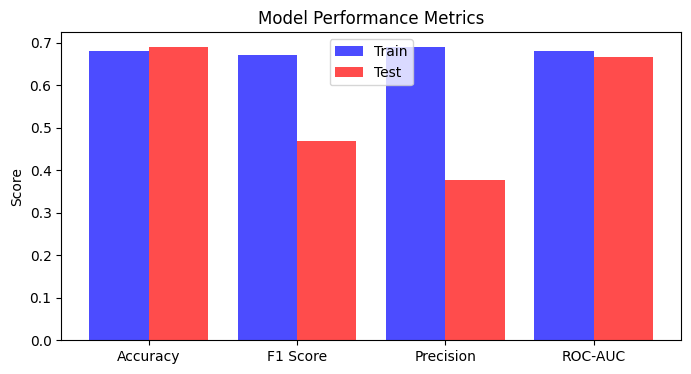

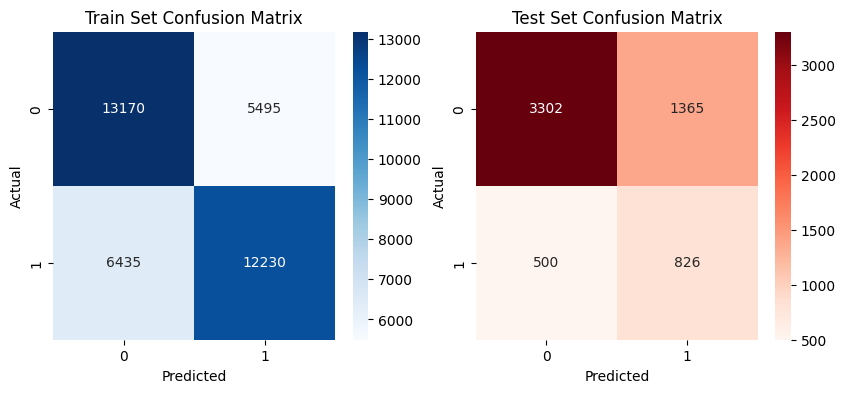

In [38]:
# For initial dataset
X_train, X_test, y_train, y_test = train_test_split(X_init.copy(), y_init.copy(), test_size=0.2, random_state=42, stratify=y_init.copy())

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

svm = LinearSVC(class_weight='balanced', random_state=42)
svm.fit(X_train_resampled, y_train_resampled)

evaluate_model(svm, X_train_resampled, y_train_resampled, X_test_scaled, y_test)

The model performs reasonably well on the training set, with balanced precision and recall (indicated by the F1 score). Precision for the minority class is low, while recall is high, overall f1 is low due to that. This trade-off is common in imbalanced datasets and reflects a bias toward catching defaults (high recall) at the expense of precision. This can be addressed by adjusting the threshold. But I guess that for this problem having higher recall is more important to minimize the risk. Drop in F1 score and precision on the test set suggests that while SMOTE helped address imbalance during training, it may have introduced some overfitting or noise, especially for class 1.

Train Set
Accuracy: 0.701
F1 Score: 0.655
Precision: 0.775
ROC-AUC: 0.701
              precision    recall  f1-score   support

           0       0.66      0.84      0.74     18665
           1       0.77      0.57      0.66     18665

    accuracy                           0.70     37330
   macro avg       0.72      0.70      0.70     37330
weighted avg       0.72      0.70      0.70     37330


Test Set
Accuracy: 0.771
F1 Score: 0.513
Precision: 0.484
ROC-AUC: 0.691
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      4667
           1       0.48      0.55      0.51      1326

    accuracy                           0.77      5993
   macro avg       0.68      0.69      0.68      5993
weighted avg       0.78      0.77      0.78      5993



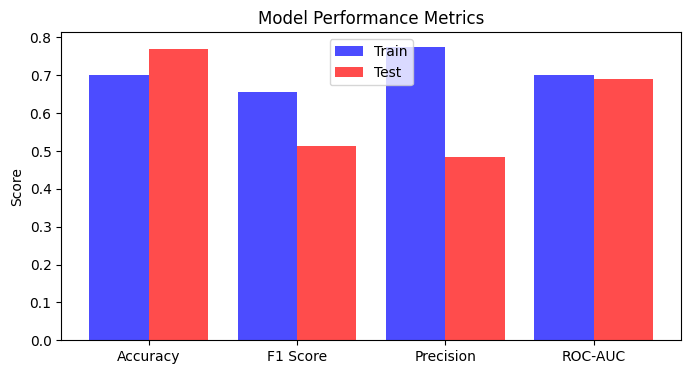

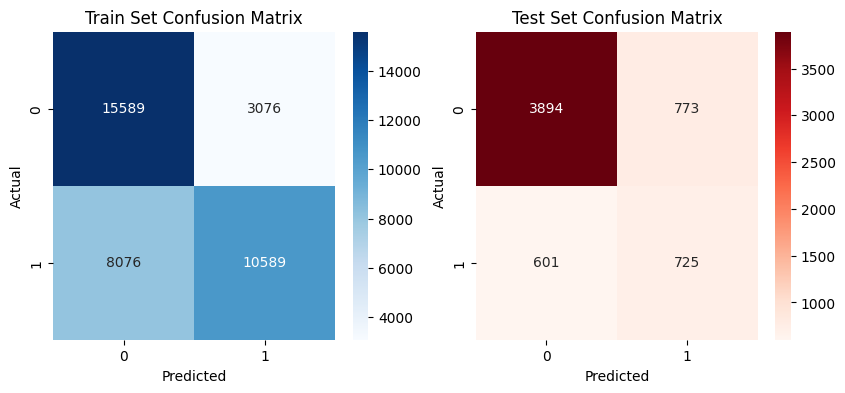

In [39]:
# For featured dataset
X_train, X_test, y_train, y_test = train_test_split(X_fetured.copy(), y_fetured.copy(), test_size=0.2, random_state=42, stratify=y_fetured.copy())

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

svm = LinearSVC(class_weight='balanced', random_state=42)
svm.fit(X_train_resampled, y_train_resampled)

evaluate_model(svm, X_train_resampled, y_train_resampled, X_test_scaled, y_test)

Precision for class 1 is moderate (48.4%) but lower than on the training set, indicating some overfitting or difficulty generalizing to unseen data. ROC-AUC is slightly lower than on the training set but still indicates moderate power. Results with feature engineering differ slightly from initial results, but have signs of overfitting. 

As we work with clinets that can potentially have high risk and the organization can have losses if the default clinets are not correctly detected, we can change (lower) threshold to have higher recall as mentioned above. Firstly we plot and calculate the best threshold via maximizing f1 score, then change that by hand to get higher recall.

In [40]:
def get_opt_threshold(y_test, y_probs):
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

    # Generating more threshold values for finer granularity
    fine_thresholds = np.linspace(0, 1, 1000)
    fine_precisions = np.interp(fine_thresholds, thresholds, precisions[:-1])
    fine_recalls = np.interp(fine_thresholds, thresholds, recalls[:-1])

    # Finding the optimal threshold via Maximizing F1-score 
    f1_scores = 2 * (fine_precisions * fine_recalls) / (fine_precisions + fine_recalls + 1e-9)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = fine_thresholds[optimal_idx]

    plt.figure(figsize=(8, 4))
    plt.plot(fine_thresholds, fine_precisions, label="Precision", color='b')
    plt.plot(fine_thresholds, fine_recalls, label="Recall", color='r')
    plt.axvline(x=optimal_threshold, color='g', linestyle="--", label=f"Optimal Threshold: {optimal_threshold:.2f}")

    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Precision-Recall Tradeoff (Finer Thresholds)")
    plt.legend()
    plt.grid(alpha=0.1)
    plt.show()

    return optimal_threshold


Original Threshold Performance:
              precision    recall  f1-score   support

           0       0.87      0.82      0.85      4667
           1       0.48      0.56      0.52      1326

    accuracy                           0.77      5993
   macro avg       0.67      0.69      0.68      5993
weighted avg       0.78      0.77      0.77      5993



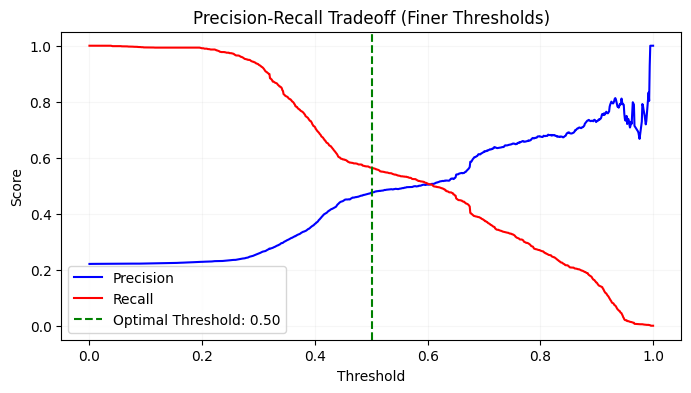

Optimized Threshold Performance:
              precision    recall  f1-score   support

           0       0.87      0.82      0.85      4667
           1       0.48      0.56      0.52      1326

    accuracy                           0.77      5993
   macro avg       0.67      0.69      0.68      5993
weighted avg       0.78      0.77      0.77      5993

--------------------------------------------------------------------------------
Adjusted Threshold Performance (higher recall):
              precision    recall  f1-score   support

           0       0.88      0.69      0.77      4667
           1       0.38      0.68      0.49      1326

    accuracy                           0.69      5993
   macro avg       0.63      0.69      0.63      5993
weighted avg       0.77      0.69      0.71      5993



In [ ]:
# Getting predicted probabilities for positive class
X_train, X_test, y_train, y_test = train_test_split(X_fetured.copy(), y_fetured.copy(), test_size=0.2, random_state=42, stratify=y_fetured.copy())
y_probs = lr_pipeline_featured.predict_proba(X_test)[:, 1]

# Getting original predictions
y_pred_original = lr_pipeline_featured.predict(X_test)

print("Original Threshold Performance:")
print(classification_report(y_test, y_pred_original))

# Optimal threshold 
optimal_threshold = get_opt_threshold(y_test, y_probs)
y_pred_adjusted = (y_probs >= optimal_threshold).astype(int)

print("Optimized Threshold Performance:")
print(classification_report(y_test, y_pred_adjusted))

# Changed value according to graph
optimal_threshold = 0.41
y_pred_adjusted = (y_probs >= optimal_threshold).astype(int)

print('-' * 80)
print("Adjusted Threshold Performance (higher recall):")
print(classification_report(y_test, y_pred_adjusted))

We can see from the results, that recall is higher in cost of low precision for the minority class.

# Hyperparameter tuning

In [42]:
lr_params = {
    'logisticregression__C': np.logspace(-3, 2, 6),  # Stronger regularization
    'logisticregression__penalty': ['l1', 'l2']
}

svm_params = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': ['scale', 'auto', 0.01],
    'svc__kernel': ['rbf', 'poly']
}

models = {
    'Logistic Regression with initial data': (lr_pipeline_init, lr_params),
    'Logistic Regression with featured data': (lr_pipeline_featured, lr_params),
    'SVM with initial data': (svm_pipeline_init, svm_params),
    'SVM with featured data': (svm_pipeline_featured, svm_params)
}

In [43]:
# Initial run 171m 49s
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve
best_models = {}
cv_results = []

for name, (pipeline, params) in models.items():
    print(f"\n=== Tuning {name} ===")
    
    # Selecting appropriate dataset based on model name
    if 'initial data' in name.lower():
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), num_cols_init),
                ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols_init)
            ])
        X_train, X_test, y_train, y_test = train_test_split(
            X_init.copy(), 
            y_init.copy(), 
            test_size=0.2, 
            random_state=42, 
            stratify=y_init.copy()
        )
    else:  # featured data
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), num_cols_featured),
                ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols_featured)
            ])
        X_train, X_test, y_train, y_test = train_test_split(
            X_fetured.copy(), 
            y_fetured.copy(), 
            test_size=0.2, 
            random_state=42, 
            stratify=y_fetured.copy()
        )
    
    pipeline.steps[0] = ('preprocessor', preprocessor)
    
    gs = GridSearchCV(
        pipeline, 
        params, 
        cv=StratifiedKFold(5, shuffle=True, random_state=42),
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )
    
    start_time = time.time()
    gs.fit(X_train, y_train)
    end_time = time.time()
    
    best_models[name] = gs.best_estimator_
    cv_results.append({
        'model': name,
        'best_score': gs.best_score_,
        'best_params': gs.best_params_,
        'test_score': gs.score(X_test, y_test)  
    })
    
    print(f"Best {name} params: {gs.best_params_}")
    print(f"Best CV ROC-AUC: {gs.best_score_:.3f}")
    print(f"Test Set ROC-AUC: {gs.score(X_test, y_test):.3f}")
    print(f"\nFitting Time: {(end_time - start_time):.2f} seconds")



=== Tuning Logistic Regression with initial data ===
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Logistic Regression with initial data params: {'logisticregression__C': np.float64(1.0), 'logisticregression__penalty': 'l1'}
Best CV ROC-AUC: 0.725
Test Set ROC-AUC: 0.716

Fitting Time: 10.96 seconds

=== Tuning Logistic Regression with featured data ===
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Logistic Regression with featured data params: {'logisticregression__C': np.float64(1.0), 'logisticregression__penalty': 'l2'}
Best CV ROC-AUC: 0.761
Test Set ROC-AUC: 0.751

Fitting Time: 12.51 seconds

=== Tuning SVM with initial data ===
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best SVM with initial data params: {'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Best CV ROC-AUC: 0.761
Test Set ROC-AUC: 0.750

Fitting Time: 5300.43 seconds

=== Tuning SVM with featured data ===
Fitting 5 folds for each of 18 candidates, t

Logistic Regression Analysis:
- Logistic Regression results improved after feature engineering, suggesting that new features added certain amount of linearity in the dataset and the model benefited from that.
- The best regularization parameter changed from L1 penalty (lasso) to L2 penalty (ridge regularization) when using featured data, so it can be implied that feature engineering introduced useful information, making it preferable to keep all features with L2 regularization rather than eliminating some with L1. While for the initial dataset there are some noisy features and were removed with lasso regression.
- The changed dataset likely contains moderately correlated features, where L2 regularization prevents overfitting better than L1.
- LR model multicollinearity affects the magnitude of the regression coefficients, which can worsen model performance (payment status and bill amount from correlation matrix). So maybe feature engineering removed that and model results become better.

SVM Analysis:
- Both models selected non linear RBF kernel, suggesting that our data is not entirely linearly separable.
- SVM (RBF kernel) outperformed Logistic Regression for corresponding datasets, but did not benefit from feature engineering a lot, suggesting that RBF kernel already captured key patterns from the original dataset. Although the execution time decreased with fewer features of new data. 
- The best chosen parameters are different, suggesting that new features changed the data structure. For featured data lower regularization parameter was needed, possibly to avoid overfitting.

From the SVM nonlinear kernel choice and performance improvement in Logistic regression after changing the dataset we can suppose that the initial data is not fully  linearly separable.


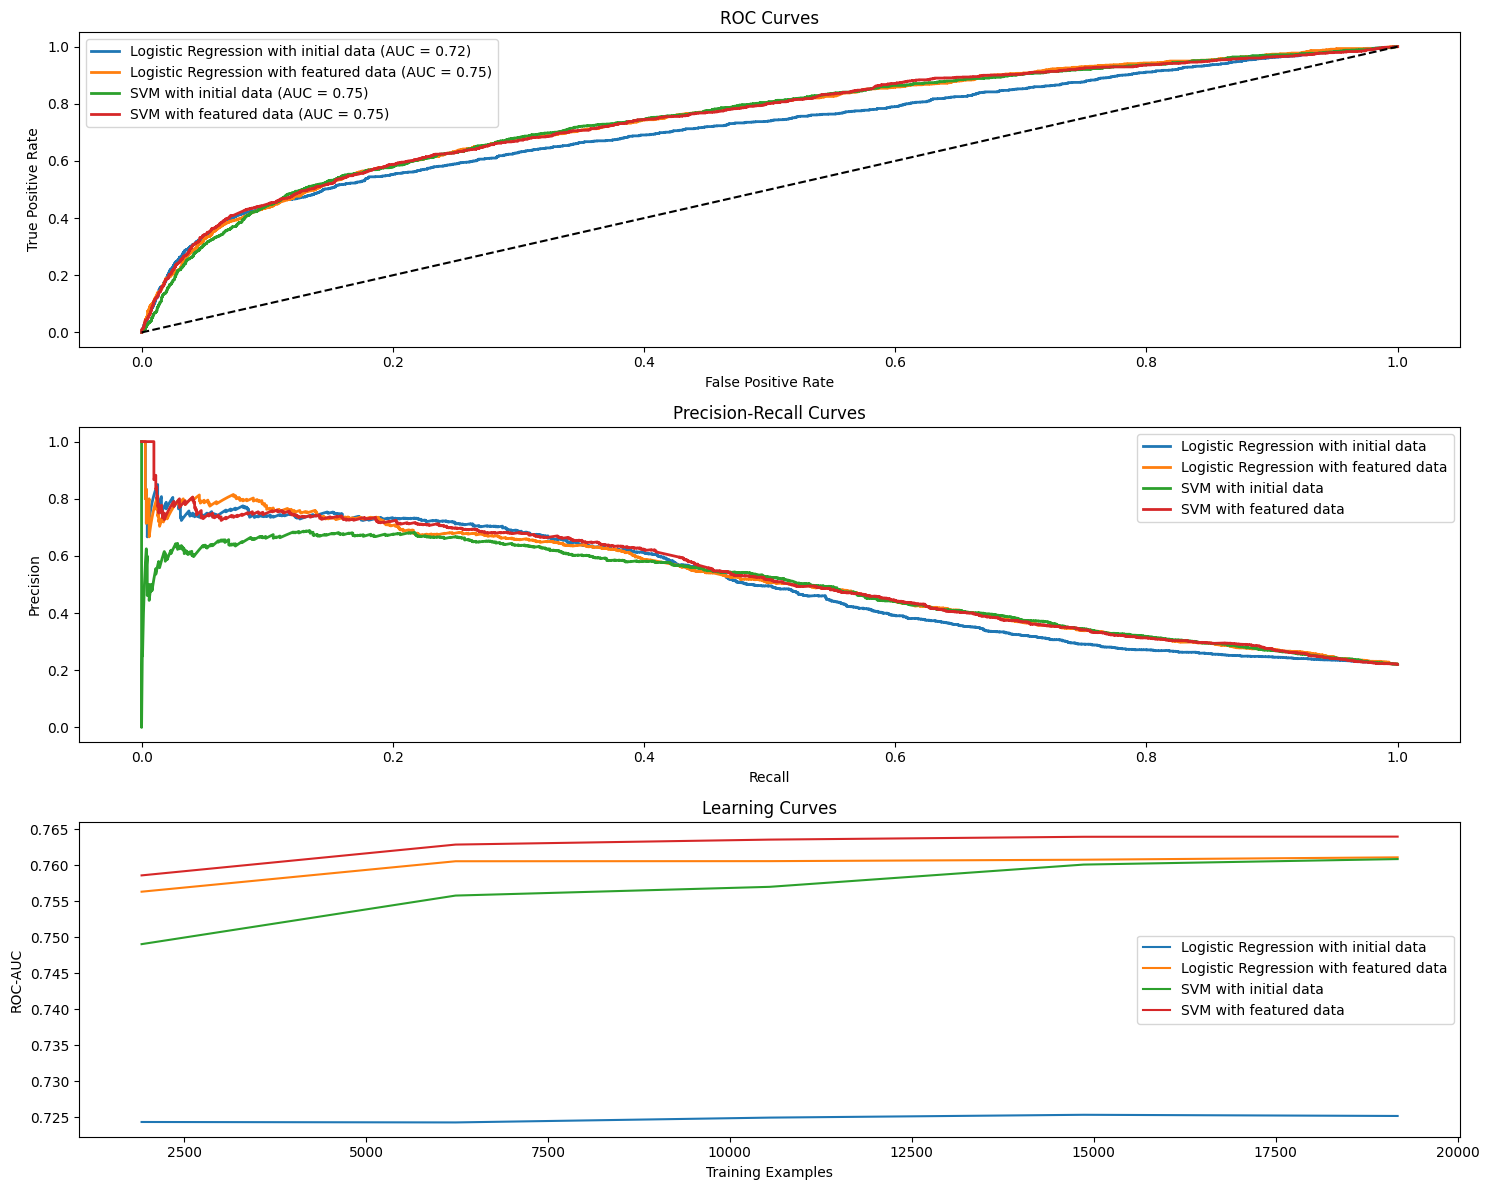

ROC Curve Time: 12.87 seconds
Precision-Recall Curve Time: 11.86 seconds
Learning Curves Time: 1023.22 seconds


In [ ]:
# Initial run 16m 20s

X_train_init, X_test_init, y_train_init, y_test_init = train_test_split(
            X_init.copy(), 
            y_init.copy(), 
            test_size=0.2, 
            random_state=42, 
            stratify=y_init.copy()
        )

X_train_fetured, X_test_fetured, y_train_fetured, y_test_fetured = train_test_split(
            X_fetured.copy(), 
            y_fetured.copy(), 
            test_size=0.2, 
            random_state=42, 
            stratify=y_fetured.copy()
        )


plt.figure(figsize=(15, 12))

# ROC Curve
plt.subplot(3, 1, 1)
start_time = time.time()
for name, model in best_models.items():
    # Selecting appropriate dataset
    if 'initial data' in name.lower():
        X_train_curr = X_train_init
        X_test_curr = X_test_init
        y_train_curr = y_train_init
        y_test_curr = y_test_init
    else:
        X_train_curr = X_train_fetured
        X_test_curr = X_test_fetured
        y_train_curr = y_train_fetured
        y_test_curr = y_test_fetured
    
    if hasattr(model, 'predict_proba'):
        fpr, tpr, _ = roc_curve(y_test_curr, model.predict_proba(X_test_curr)[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
end_time = time.time()
roc_curve_time = end_time - start_time

# Precision-Recall Curve
plt.subplot(3, 1, 2)
start_time = time.time()
for name, model in best_models.items():
    if 'initial data' in name.lower():
        X_test_curr = X_test_init
        y_test_curr = y_test_init
    else:
        X_test_curr = X_test_fetured
        y_test_curr = y_test_fetured
    
    if hasattr(model, 'predict_proba'):
        precision, recall, _ = precision_recall_curve(y_test_curr, 
                                                    model.predict_proba(X_test_curr)[:, 1])
        plt.plot(recall, precision, lw=2, label=name)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
end_time = time.time()
precision_recall = end_time - start_time

# Learning Curves
plt.subplot(3, 1, 3)
start_time = time.time()
for name, model in best_models.items():
    if 'initial data' in name.lower():
        X_train_curr = X_train_init
        y_train_curr = y_train_init
    else:
        X_train_curr = X_train_fetured
        y_train_curr = y_train_fetured
    
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train_curr, y_train_curr, 
        cv=StratifiedKFold(5, shuffle=True, random_state=42),
        train_sizes=np.linspace(0.1, 1.0, 5), 
        scoring='roc_auc',
        n_jobs=-1)

    plt.plot(train_sizes, np.mean(test_scores, axis=1), label=name)

plt.xlabel('Training Examples')
plt.ylabel('ROC-AUC')
plt.title('Learning Curves')
plt.legend()
end_time = time.time()
learning_curves = end_time - start_time

plt.tight_layout()
plt.show()

print(f"ROC Curve Time: {roc_curve_time:.2f} seconds")
print(f"Precision-Recall Curve Time: {precision_recall:.2f} seconds")
print(f"Learning Curves Time: {learning_curves:.2f} seconds")

Final interpretation of the results are discussed in the report.